In [15]:
import sys
sys.path.append('/home/fenglab/Desktop/transdiff_GRN/src/')

from find_modules import *
from topology import *
from rank_centrality import *
from scipy.stats import fisher_exact
from scipy.stats import ranksums
from statsmodels.stats import multitest

random_s = 10
random.seed(random_s)

In [8]:
with open('./../data/QuickGO-annotations-TFs.tsv', 'r') as f:
    lines = f.readlines()
tfs = [line.split('\t')[2] for line in lines[1:]]

with open('./../data/grn_expression.txt', 'r') as f:
    lines = f.readlines()
genes = [line.split('\t')[0] for line in lines[1:]]

grntfs = list(set(tfs)&set(genes))

In [9]:
treatments = ['Anp', 'AMn', 'AMp', 'AMnp']
colors = {'Anp':'#0088ff', 'AMn':'#ff6f00', 'AMp':'#00e883', 'AMnp':'#ffbf00'}

In [10]:
def node_count_group(df):
    xt = [b for (a,b) in df.groupby(['run','nodes']).count().index]
    xt_plot = np.array(np.round(np.array(xt)/50)*50, dtype=int)

    # count non-TFs
    yntf = df[~df['geneid'].isin(grntfs)].groupby(['run','nodes']).count()[['geneid']].to_numpy().flatten()
    # count total genes
    yt = df.groupby(['run','nodes']).count()[['geneid']].to_numpy().flatten()
    # count non-TFs with positive betweenness centrality
    yntfn = df[(~df['geneid'].isin(grntfs))&(df['betweenness_centrality']>0)].groupby(['run','nodes'])\
            .count()[['geneid']].to_numpy().flatten()
    # count genes with positive betweenness centrality
    yn = df[df['betweenness_centrality']>0].groupby(['run','nodes']).count()[['geneid']].to_numpy().flatten()

    dfplt = pd.DataFrame([xt_plot,(yntf-yntfn)/yt*100,
                  (yt-yn-yntf+yntfn)/yt*100,
                  yntfn/yt*100,
                  (yn-yntfn)/yt*100], index=['plotnodes','nonTF0','TF0','nonTF','TF']).T
    dfplt = dfplt[dfplt['plotnodes']>0]

    bar = dfplt.groupby('plotnodes').mean()
    err = dfplt.groupby('plotnodes').std()
    return bar,err

In [11]:
def TF_btw_fisher_test(df):
    # count non-TFs
    yntf = df[~df['geneid'].isin(grntfs)].groupby(['run','nodes']).count()[['geneid']].to_numpy().flatten()
    # count total genes
    yt = df.groupby(['run','nodes']).count()[['geneid']].to_numpy().flatten()
    # count non-TFs with positive betweenness centrality
    yntfn = df[(~df['geneid'].isin(grntfs))&(df['betweenness_centrality']>0)].groupby(['run','nodes'])\
            .count()[['geneid']].to_numpy().flatten()
    # count genes with positive betweenness centrality
    yn = df[df['betweenness_centrality']>0].groupby(['run','nodes']).count()[['geneid']].to_numpy().flatten()

    dfct = pd.DataFrame([yt,(yntf-yntfn),
                  (yt-yn-yntf+yntfn),
                  yntfn,
                  (yn-yntfn)], index=['nodes','nonTF0','TF0','nonTF','TF']).T
    dfct = dfct[dfct['nodes']>50]
    
    rs=[]
    ps=[]
    for n in range(len(dfct)):
        (r,p) = fisher_exact(np.reshape(dfct.to_numpy()[n,1:],(2,2)), alternative='two-sided')
        rs.append(r)
        ps.append(p)
    dfct['Odds'] = rs
    dfct['p'] = ps
    return dfct

In [12]:
def TF_btw_wilcoxon_test(df):
    # non-TFs
    dfp1 = df[(~df['geneid'].isin(grntfs))][['run','nodes','betweenness_centrality']]
    dfp1 = dfp1[dfp1['nodes']>50]
    # TFs
    dfp2 = df[(df['geneid'].isin(grntfs))][['run','nodes','betweenness_centrality']]
    dfp2 = dfp2[dfp2['nodes']>50]
    
    xt = [(a,b) for (a,b) in dfp2.groupby(['run','nodes']).count().index]
    
    ss = []
    ps = []
    for (a,b) in xt:
        (s,p)=ranksums(dfp2[(dfp2['run']==a)&(dfp2['nodes']==b)]['betweenness_centrality'],
                        dfp1[(dfp1['run']==a)&(dfp1['nodes']==b)]['betweenness_centrality'])
        ss.append(s)
        ps.append(p)
    dfct = dfp2.groupby(['run','nodes']).count()
    dfct['stats'] = ss
    dfct['p'] = ps
    return dfct.drop(columns=['betweenness_centrality'])

In [13]:
df = pd.read_csv(f'./../results/centrality_{treatments[0]}.txt', sep='\t')
dffs = TF_btw_fisher_test(df)
dfrs = TF_btw_wilcoxon_test(df)
bar,err = node_count_group(df)

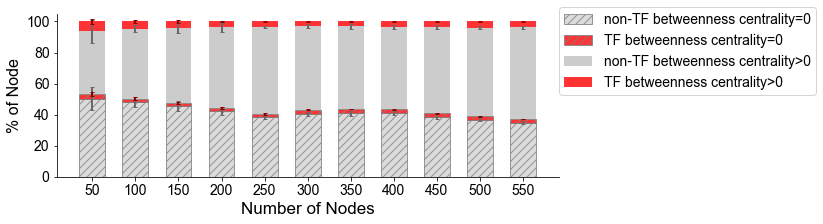

In [39]:
fig, ax = plt.subplots(figsize=(9, 3))
mpl.rcParams['hatch.linewidth']=1
ax.bar(bar.index, bar['nonTF0'], color='lightgrey', width=30, alpha=0.8,hatch='///',edgecolor='grey',
      label='non-TF betweenness centrality=0')
ax.bar(bar.index, bar['TF0'], color = 'red', bottom = bar['nonTF0'], width=30, alpha=0.8,hatch='///',
       edgecolor='grey', label='TF betweenness centrality=0')
ax.bar(bar.index, bar['nonTF'], color = 'silver', bottom = bar['TF0']+bar['nonTF0'], width=30, alpha=0.8,
      label='non-TF betweenness centrality>0')
ax.bar(bar.index, bar['TF'], color = 'red', bottom = bar['nonTF']+bar['TF0']+bar['nonTF0'], width=30, alpha=0.8,
      label='TF betweenness centrality>0')

plt.errorbar(bar.index, bar['nonTF0'],yerr=err['nonTF0'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0'],yerr=err['TF0'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF'],yerr=err['nonTF'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF']+bar['TF'],yerr=err['TF'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)

plt.legend(loc=(1,0.5),prop={'size':14})
plt.xlabel('Number of Nodes', fontsize=17)
plt.ylabel('% of Node', fontsize=16)
plt.ylim(top=105,bottom=0)
plt.xticks(bar.index,fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.savefig('./../figs/S2A1.svg', pad_inches=0.1, bbox_inches='tight')

    nodes  nonTF0  TF0  nonTF  TF      Odds         p
3     150      75    1     66   8  9.090909  0.016859
84    109      58    0     46   5       inf  0.020107


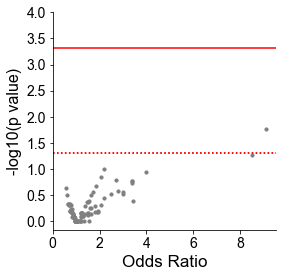

In [25]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dffs['Odds'], -np.log10(dffs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dffs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
plt.xlabel('Odds Ratio', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim(left=0)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.savefig('./../figs/S2A2.svg', pad_inches=0.1, bbox_inches='tight')
print(dffs[dffs['p']<0.05])

              stats         p
run nodes                    
1   150    2.330540  0.019778
    201    2.423124  0.015388
7   150    2.139718  0.032378
8   109    3.244447  0.001177
    158    2.164330  0.030439
9   154    2.030849  0.042270


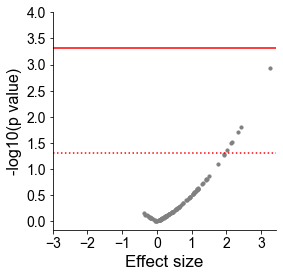

In [26]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dfrs['stats'], -np.log10(dfrs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dfrs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Effect size', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=-3)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.savefig('./../figs/S2A3.svg', pad_inches=0.1, bbox_inches='tight')
print(dfrs[dfrs['p']<0.05])

In [27]:
df = pd.read_csv(f'./../results/centrality_{treatments[1]}.txt', sep='\t')
dffs = TF_btw_fisher_test(df)
dfrs = TF_btw_wilcoxon_test(df)
bar,err = node_count_group(df)

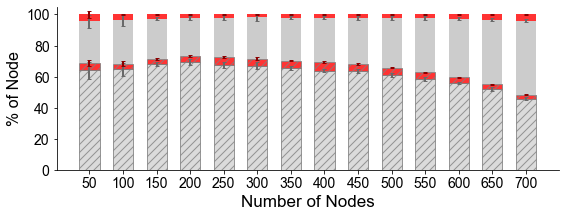

In [31]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.bar(bar.index, bar['nonTF0'], color='lightgrey', width=30, alpha=0.8,hatch='///',edgecolor='grey')
ax.bar(bar.index, bar['TF0'], color = 'red', bottom = bar['nonTF0'], width=30, alpha=0.8,hatch='///',edgecolor='grey')
ax.bar(bar.index, bar['nonTF'], color = 'silver', bottom = bar['TF0']+bar['nonTF0'], width=30, alpha=0.8)
ax.bar(bar.index, bar['TF'], color = 'red', bottom = bar['nonTF']+bar['TF0']+bar['nonTF0'], width=30, alpha=0.8)

plt.errorbar(bar.index, bar['nonTF0'],yerr=err['nonTF0'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0'],yerr=err['TF0'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF'],yerr=err['nonTF'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF']+bar['TF'],yerr=err['TF'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)

plt.xlabel('Number of Nodes', fontsize=17)
plt.ylabel('% of Node', fontsize=16)
plt.ylim(top=105,bottom=0)
plt.xticks(bar.index,fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.savefig('./../figs/S2B1.svg', pad_inches=0.1, bbox_inches='tight')

    nodes  nonTF0  TF0  nonTF  TF       Odds         p
2     100      65    1     30   4   8.666667  0.044351
17    103      77    1     21   4  14.666667  0.011878


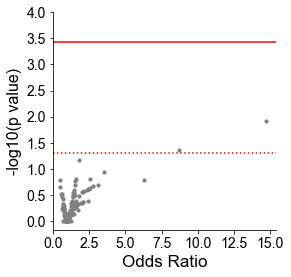

In [30]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dffs['Odds'], -np.log10(dffs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dffs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Odds Ratio', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=0)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.savefig('./../figs/S2B2.svg', pad_inches=0.1, bbox_inches='tight')
print(dffs[dffs['p']<0.05])

              stats         p
run nodes                    
1   100    2.309064  0.020940
2   103    2.056273  0.039756


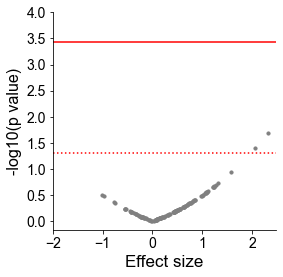

In [31]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dfrs['stats'], -np.log10(dfrs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dfrs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Effect size', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=-2)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.savefig('./../figs/S2B3.svg', pad_inches=0.1, bbox_inches='tight')
print(dfrs[dfrs['p']<0.05])

In [32]:
df = pd.read_csv(f'./../results/centrality_{treatments[2]}.txt', sep='\t')
dffs = TF_btw_fisher_test(df)
dfrs = TF_btw_wilcoxon_test(df)
bar,err = node_count_group(df)

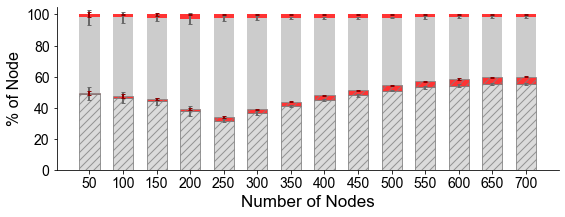

In [33]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.bar(bar.index, bar['nonTF0'], color='lightgrey', width=30, alpha=0.8,hatch='///',edgecolor='grey')
ax.bar(bar.index, bar['TF0'], color = 'red', bottom = bar['nonTF0'], width=30, alpha=0.8,hatch='///',edgecolor='grey')
ax.bar(bar.index, bar['nonTF'], color = 'silver', bottom = bar['TF0']+bar['nonTF0'], width=30, alpha=0.8)
ax.bar(bar.index, bar['TF'], color = 'red', bottom = bar['nonTF']+bar['TF0']+bar['nonTF0'], width=30, alpha=0.8)

plt.errorbar(bar.index, bar['nonTF0'],yerr=err['nonTF0'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0'],yerr=err['TF0'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF'],yerr=err['nonTF'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF']+bar['TF'],yerr=err['TF'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)

plt.xlabel('Number of Nodes', fontsize=17)
plt.ylabel('% of Node', fontsize=16)
plt.ylim(top=105,bottom=0)
plt.xticks(bar.index,fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.savefig('./../figs/S2C1.svg', pad_inches=0.1, bbox_inches='tight')

     nodes  nonTF0  TF0  nonTF  TF      Odds         p
12     604     324   30    241   9  0.403320  0.018116
86     650     355   32    253  10  0.438488  0.023248
87     706     391   33    271  11  0.480935  0.039138
131    652     361   30    251  10  0.479416  0.046909


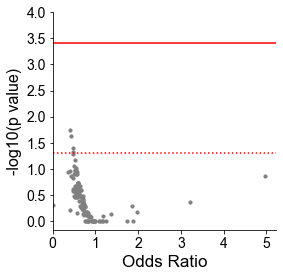

In [34]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dffs['Odds'], -np.log10(dffs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dffs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Odds Ratio', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=0)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.savefig('./../figs/S2C2.svg', pad_inches=0.1, bbox_inches='tight')
print(dffs[dffs['p']<0.05])

Empty DataFrame
Columns: [stats, p]
Index: []


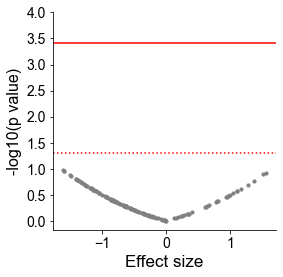

In [35]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dfrs['stats'], -np.log10(dfrs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dfrs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Effect size', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim(left=-7)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.savefig('./../figs/S2C3.svg', pad_inches=0.1, bbox_inches='tight')
print(dfrs[dfrs['p']<0.05])

In [36]:
df = pd.read_csv(f'./../results/centrality_{treatments[3]}.txt', sep='\t')
dffs = TF_btw_fisher_test(df)
dfrs = TF_btw_wilcoxon_test(df)
bar,err = node_count_group(df)

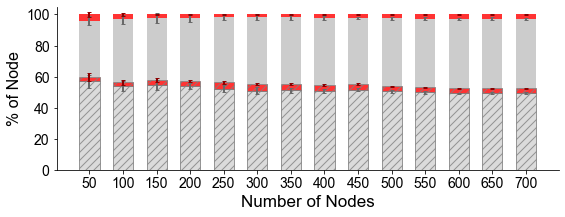

In [37]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.bar(bar.index, bar['nonTF0'], color='lightgrey', width=30, alpha=0.8,hatch='///',edgecolor='grey')
ax.bar(bar.index, bar['TF0'], color = 'red', bottom = bar['nonTF0'], width=30, alpha=0.8,hatch='///',edgecolor='grey')
ax.bar(bar.index, bar['nonTF'], color = 'silver', bottom = bar['TF0']+bar['nonTF0'], width=30, alpha=0.8)
ax.bar(bar.index, bar['TF'], color = 'red', bottom = bar['nonTF']+bar['TF0']+bar['nonTF0'], width=30, alpha=0.8)

plt.errorbar(bar.index, bar['nonTF0'],yerr=err['nonTF0'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0'],yerr=err['TF0'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF'],yerr=err['nonTF'], color='dimgrey',fmt='none',
             capsize=2,elinewidth=2)
plt.errorbar(bar.index, bar['nonTF0']+bar['TF0']+bar['nonTF']+bar['TF'],yerr=err['TF'], color='darkred',fmt='none',
             capsize=2,elinewidth=2)

plt.xlabel('Number of Nodes', fontsize=17)
plt.ylabel('% of Node', fontsize=16)
plt.ylim(top=105,bottom=0)
plt.xticks(bar.index,fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.savefig('./../figs/S2D1.svg', pad_inches=0.1, bbox_inches='tight')

    nodes  nonTF0  TF0  nonTF  TF      Odds         p
81    303     163   17    119   4  0.322294  0.039853
96    300     144   15    137   4  0.280292  0.030147


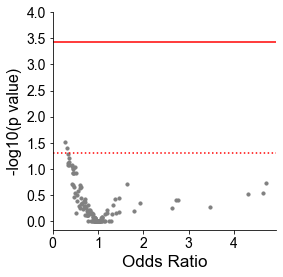

In [37]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dffs['Odds'], -np.log10(dffs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dffs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Odds Ratio', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=0)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.savefig('./../figs/S2D2.svg', pad_inches=0.1, bbox_inches='tight')
print(dffs[dffs['p']<0.05])

              stats         p
run nodes                    
5   100    2.465150  0.013696
8   51     2.562050  0.010406
    116    1.971148  0.048707


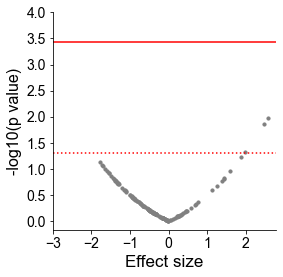

In [38]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
plt.scatter(dfrs['stats'], -np.log10(dfrs['p']), s=10, color='grey')
plt.axhline(y=-np.log10(0.05), color='red', linestyle=':')
_,_,_,fdrp = multitest.multipletests(dfrs['p'],method='fdr_bh',is_sorted=False, returnsorted=True)
plt.axhline(y=-np.log10(fdrp), color='red', linestyle='-')

plt.xlabel('Effect size', fontsize=17)
plt.ylabel('-log10(p value)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=-3)
plt.ylim(top=4)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.savefig('./../figs/S2D3.svg', pad_inches=0.1, bbox_inches='tight')
print(dfrs[dfrs['p']<0.05])